# Listing 4-1a. Continuous Bag of Words Implementation in TensorFlow 

In [2]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
emb_dims = 128
from tensorflow.keras import Model, layers
import time
#-------------------------------------------------
# to one hot the words
#------------------------------------------------
def one_hot(ind,vocab_size):
    rec = np.zeros(vocab_size)
    rec[ind] = 1
    return rec


#----------------------------------------------------
# Create training data
#----------------------------------------------------
def create_training_data(corpus_raw,WINDOW_SIZE = 2):
    words_list = []

    for sent in corpus_raw.split('.'):
        for w in sent.split():
            if w != '.':  
                words_list.append(w.split('.')[0])       # Remove if delimiter is tied to the end of a word

    words_list = set(words_list)                     # Remove the duplicates for each word 

    word2ind = {}                                    # Define the dictionary for converting a word to index
    ind2word = {}                                    # Define dictionary for retrieving a word from its index

    vocab_size = len(words_list)                      # Count of unique words in the vocabulary

    for i,w in enumerate(words_list):                 # Build the dictionaries  
        word2ind[w] = i
        ind2word[i] = w
        
    #print(word2ind)
    sentences_list = corpus_raw.split('.')
    sentences = []

    for sent in sentences_list:
        sent_array = sent.split()
        sent_array = [s.split('.')[0] for s in sent_array]
        sentences.append(sent_array)               # finally sentences would hold arrays of word array for sentences
    
    data_recs = []                                   # Holder for the input output record

    

    for sent in sentences:
        for ind,w in enumerate(sent):
            rec = []
            for nb_w in sent[max(ind - WINDOW_SIZE, 0) : min(ind + WINDOW_SIZE, len(sent)) + 1] : 
                if nb_w != w:
                    rec.append(nb_w)
                data_recs.append([rec,w])
    
    x_train,y_train = [],[]

    for rec in data_recs:
        input_ = np.zeros(vocab_size)
        for i in range(len(rec[0])):
            input_ += one_hot(word2ind[ rec[0][i] ], vocab_size)
        input_ = input_/len(rec[0])
        x_train.append(input_)
        y_train.append(one_hot(word2ind[ rec[1] ], vocab_size))
        
    return x_train,y_train,word2ind,ind2word,vocab_size


class CBOW(Model):
    
    def __init__(self,vocab_size,embedding_size):
        super(CBOW,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
      
        
        self.embedding_layer = layers.Dense(self.embedding_size) # input is vocab_size: vocab_size x embedding_size
        self.output_layer = layers.Dense(self.vocab_size) # embedding_size x vocab size
        
    def call(self,x):
        x = self.embedding_layer(x)
        x = self.output_layer(x)
        return x
        
def shuffle_train(X_train,y_train):
    num_recs_train = X_train.shape[0]
    indices = np.arange(num_recs_train)
    np.random.shuffle(indices)
    return X_train[indices],y_train[indices]

def train_embeddings(training_corpus,epochs=100,lr=0.01,batch_size=32,embedding_size=32):
    
    training_corpus = (training_corpus).lower()
    #----------------------------------------------------------------------
    # Invoke the training data generation the corpus data
    #-----------------------------------------------------------------------
    X_train,y_train,word2ind,ind2word,vocab_size= create_training_data(training_corpus,2)
    
    print(f"Vocab size: {vocab_size}")
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    model = CBOW(vocab_size=vocab_size,embedding_size=embedding_size)
    model_graph = tf.function(model)
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.SUM)
    optimizer = tf.keras.optimizers.Adam(lr)

    num_train_recs = X_train.shape[0]
    num_batches = num_train_recs // batch_size
    loss_trace , accuracy_trace = [],[]
    start_time = time.time()
    
    for i in range(epochs):
        
        loss = 0
        X_train, y_train = shuffle_train(X_train,y_train)
        
        for j in range(num_batches):
            X_train_batch = tf.constant(X_train[j * batch_size:(j + 1) * batch_size], dtype=tf.float32)
            y_train_batch = tf.constant(y_train[j * batch_size:(j + 1) * batch_size])
            
            with tf.GradientTape() as tape:
                y_pred_batch = model_graph(X_train_batch,training=True)
                loss_ = loss_fn(y_train_batch, y_pred_batch)
    
            # compute gradient
            gradients = tape.gradient(loss_, model.trainable_variables)
            # update the parameters
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
            loss += loss_.numpy()
        loss /= num_train_recs
        loss_trace.append(loss)
        if i % 5 == 0:
            print(f"Epoch {i} : loss: {np.round(loss, 4)}  \n")
        
    embeddings =  model_graph.embedding_layer.get_weights()[0]
    print(f"Emeddings shape : {embeddings.shape} ")
    return embeddings,ind2word

training_corpus = "Deep Learning has evolved from Artificial Neural Networks which has been there since the 1940s. Neural Networks are interconnected networks of processing units called artificial neurons, that loosely mimics axons in a biological brain. In a biological neuron, the Dendrites receive input signals from various neighboring neurons, typically greater than 1000. These modified signals are then passed on to the cell body or soma of the neuron where these signals are summed together and then passed on to the Axon of the neuron. If the received input signal is more than a specified threshold, the axon will release a signal which again will pass on to neighboring dendrites of other neurons. Figure 2-1 depicts the structure of a biological neuron for reference.The artificial neuron units are inspired from the biological neurons with some modifications as per convenience. Much like the dendrites the input connections to the neuron carry the attenuated or amplified input signals from other neighboring neurons. The signals are passed onto the neuron where the input signals are summed up and then a decision is taken what to output based on the total input received. For instance, for a binary threshold neuron output value of 1 is provided when the total input exceeds a pre-defined threshold, otherwise the output stays at 0. Several other types of neurons are used in artificial neural network and their implementation only differs with respect to the activation function on the total input to produce the neuron output. In Figure 2-2 the different biological equivalents are tagged in the artificial neuron for easy analogy and interpretation."
embeddings,ind2word =  train_embeddings(training_corpus)


2.9.1
Vocab size: 128
Epoch 0 : loss: 4.5052  

Epoch 5 : loss: 0.5084  

Epoch 10 : loss: 0.0977  

Epoch 15 : loss: 0.0431  

Epoch 20 : loss: 0.0293  

Epoch 25 : loss: 0.0202  

Epoch 30 : loss: 0.0174  

Epoch 35 : loss: 0.0177  

Epoch 40 : loss: 0.015  

Epoch 45 : loss: 0.0137  

Epoch 50 : loss: 0.0141  

Epoch 55 : loss: 0.0129  

Epoch 60 : loss: 0.0149  

Epoch 65 : loss: 0.0139  

Epoch 70 : loss: 0.0117  

Epoch 75 : loss: 0.011  

Epoch 80 : loss: 0.0109  

Epoch 85 : loss: 0.0121  

Epoch 90 : loss: 0.0116  

Epoch 95 : loss: 0.0105  

Emeddings shape : (128, 32) 


/home/santanu/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/santanu/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TSNE plot of the CBOW based Word Vector Embeddings


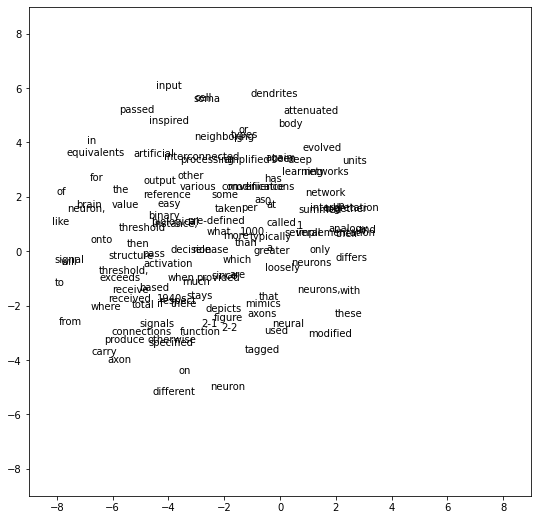

In [7]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
W_embedded = TSNE(n_components=2).fit_transform(embeddings)
plt.figure(figsize=(9,9))
for i in range(len(W_embedded)):
    plt.text(W_embedded[i,0],W_embedded[i,1],ind2word[i])

plt.xlim(-9,9)
plt.ylim(-9,9)
print("TSNE plot of the CBOW based Word Vector Embeddings")



# Listing 4-1b. Skip-Gram Implementation in TensorFlow 

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline 

#------------------------------------------------------------
# Function to one hot encode the words
#------------------------------------------------------------ 
def one_hot(ind,vocab_size):
    rec = np.zeros(vocab_size)
    rec[ind] = 1
    return rec

#----------------------------------------------------------------------
# Function to create the training data from the corpus
#---------------------------------------------------------------------- 
def create_training_data(corpus_raw,WINDOW_SIZE = 2):
    words_list = []

    for sent in corpus_raw.split('.'):
        for w in sent.split():
            if w != '.':  
                words_list.append(w.split('.')[0])       # Remove if delimiter is tied to the end of a word

    words_list = set(words_list)                     # Remove the duplicates for each word 

    word2ind = {}                                    # Define the dictionary for converting a word to index
    ind2word = {}                                    # Define dictionary for retrieving a word from its index

    vocab_size = len(words_list)                      # Count of unique words in the vocabulary

    for i,w in enumerate(words_list):                 # Build the dictionaries  
        word2ind[w] = i
        ind2word[i] = w
        
    sentences_list = corpus_raw.split('.')
    sentences = []

    for sent in sentences_list:
        sent_array = sent.split()
        sent_array = [s.split('.')[0] for s in sent_array]
        sentences.append(sent_array)               # finally sentences would hold arrays of word array for sentences
    
    data_recs = []                                   # Holder for the input output record

    

    for sent in sentences:
        for ind,w in enumerate(sent):
            for nb_w in sent[max(ind - WINDOW_SIZE, 0) : min(ind + WINDOW_SIZE, len(sent)) + 1] : 
                if nb_w != w:
                    data_recs.append([w,nb_w])
    
    x_train,y_train = [],[]
    
    #print(data_recs)
    
    for rec in data_recs:
        x_train.append(one_hot(word2ind[ rec[0] ], vocab_size))
        y_train.append(one_hot(word2ind[ rec[1] ], vocab_size))
    
    
        
    return x_train,y_train,word2ind,ind2word,vocab_size

class SkipGram(Model):
    
    def __init__(self,vocab_size,embedding_size):
        super(SkipGram,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
      
        
        self.embedding_layer = layers.Dense(self.embedding_size) # input is vocab_size: vocab_size x embedding_size
        self.output_layer = layers.Dense(self.vocab_size) # embedding_size x vocab size
        
    def call(self,x):
        x = self.embedding_layer(x)
        x = self.output_layer(x)
        return x
        
def shuffle_train(X_train,y_train):
    num_recs_train = X_train.shape[0]
    indices = np.arange(num_recs_train)
    np.random.shuffle(indices)
    return X_train[indices],y_train[indices]

def train_embeddings(training_corpus,epochs=100,lr=0.01,batch_size=32,embedding_size=32):
    
    training_corpus = (training_corpus).lower()
    #----------------------------------------------------------------------
    # Invoke the training data generation the corpus data
    #-----------------------------------------------------------------------
    X_train,y_train,word2ind,ind2word,vocab_size= create_training_data(training_corpus,2)
    
    print(f"Vocab size: {vocab_size}")
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    model = SkipGram(vocab_size=vocab_size,embedding_size=embedding_size)
    model_graph = tf.function(model)
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.SUM)
    
    #loss_fn = tf.nn.sampled_softmax_loss(num_sampled=4,
    #        num_classes=vocab_size,
    #        num_true=1)
    
    optimizer = tf.keras.optimizers.Adam(lr)

    num_train_recs = X_train.shape[0]
    num_batches = num_train_recs // batch_size
    loss_trace , accuracy_trace = [],[]
    start_time = time.time()
    
    for i in range(epochs):
        
        loss = 0
        X_train, y_train = shuffle_train(X_train,y_train)
        
        for j in range(num_batches):
            X_train_batch = tf.constant(X_train[j * batch_size:(j + 1) * batch_size], dtype=tf.float32)
            y_train_batch = tf.constant(y_train[j * batch_size:(j + 1) * batch_size])
            
            with tf.GradientTape() as tape:
                y_pred_batch = model_graph(X_train_batch,training=True)
                loss_ = loss_fn(y_train_batch, y_pred_batch)
    
            # compute gradient
            gradients = tape.gradient(loss_, model.trainable_variables)
            # update the parameters
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
            loss += loss_.numpy()
        loss /= num_train_recs
        loss_trace.append(loss)
        if i % 5 == 0:
            print(f"Epoch {i} : loss: {np.round(loss, 4)}  \n")
        
    embeddings =  model_graph.embedding_layer.get_weights()[0]
    print(f"Emeddings shape : {embeddings.shape} ")
    return embeddings, ind2word

training_corpus = "Deep Learning has evolved from Artificial Neural Networks which has been there since the 1940s. Neural Networks are interconnected networks of processing units called artificial neurons, that loosely mimics axons in a biological brain. In a biological neuron, the Dendrites receive input signals from various neighboring neurons, typically greater than 1000. These modified signals are then passed on to the cell body or soma of the neuron where these signals are summed together and then passed on to the Axon of the neuron. If the received input signal is more than a specified threshold, the axon will release a signal which again will pass on to neighboring dendrites of other neurons. Figure 2-1 depicts the structure of a biological neuron for reference.The artificial neuron units are inspired from the biological neurons with some modifications as per convenience. Much like the dendrites the input connections to the neuron carry the attenuated or amplified input signals from other neighboring neurons. The signals are passed onto the neuron where the input signals are summed up and then a decision is taken what to output based on the total input received. For instance, for a binary threshold neuron output value of 1 is provided when the total input exceeds a pre-defined threshold, otherwise the output stays at 0. Several other types of neurons are used in artificial neural network and their implementation only differs with respect to the activation function on the total input to produce the neuron output. In Figure 2-2 the different biological equivalents are tagged in the artificial neuron for easy analogy and interpretation."
embeddings, ind2word =  train_embeddings(training_corpus)



Vocab size: 128
Epoch 0 : loss: 4.6167  

Epoch 5 : loss: 3.0871  

Epoch 10 : loss: 2.5428  

Epoch 15 : loss: 2.4379  

Epoch 20 : loss: 2.3986  

Epoch 25 : loss: 2.3806  

Epoch 30 : loss: 2.3757  

Epoch 35 : loss: 2.3727  

Epoch 40 : loss: 2.3586  

Epoch 45 : loss: 2.3651  

Epoch 50 : loss: 2.3565  

Epoch 55 : loss: 2.3524  

Epoch 60 : loss: 2.3572  

Epoch 65 : loss: 2.3557  

Epoch 70 : loss: 2.3472  

Epoch 75 : loss: 2.3513  

Epoch 80 : loss: 2.333  

Epoch 85 : loss: 2.3393  

Epoch 90 : loss: 2.3385  

Epoch 95 : loss: 2.3412  

Emeddings shape : (128, 32) 


/home/santanu/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/santanu/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TSNE plot of the SkipGram based Word Vector Embeddings


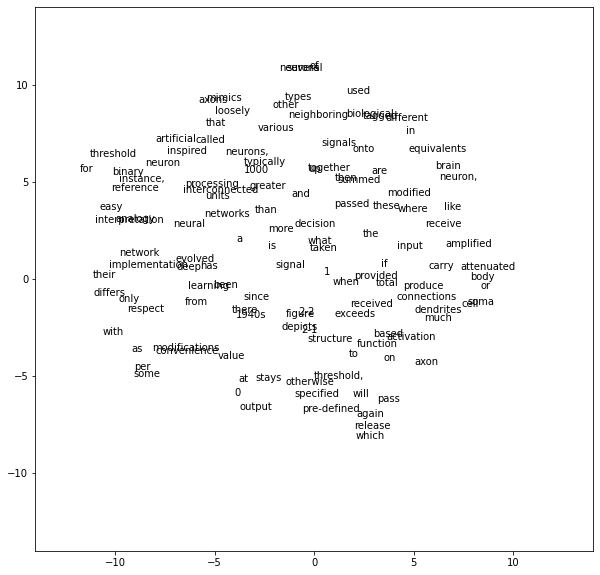

In [9]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
W_embedded = TSNE(n_components=2).fit_transform(embeddings)
plt.figure(figsize=(10,10))
for i in range(len(W_embedded)):
    plt.text(W_embedded[i,0],W_embedded[i,1],ind2word[i])

plt.xlim(-14,14)
plt.ylim(-14,14)
print("TSNE plot of the SkipGram based Word Vector Embeddings")

# Listing 4-1c Global Co-occurrence Statistics based Word Vector

['I', 'like', 'Machine', 'Learning.']
['I', 'like', 'TensorFlow.']
['I', 'prefer', 'Python.']
co_occurence_matrix follows:
[[0. 1. 0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 2. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 1. 0.]]


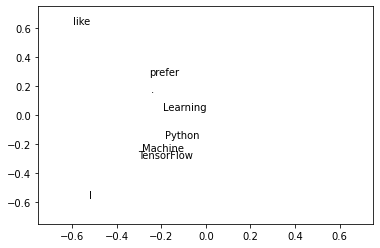

In [10]:
import numpy as np
import matplotlib.pyplot as plt


corpus = ['I like Machine Learning.','I like TensorFlow.','I prefer Python.']
corpus_words_unique = set()
corpus_processed_docs = []

# Process the documents in the corpus to create the Co-occrence count
for doc in corpus:
    corpus_words_ = []
    corpus_words = doc.split()
    print(corpus_words)
    for x in corpus_words:
        if len(x.split('.')) == 2:
            corpus_words_ += [x.split('.')[0]] + ['.']
        else:
            corpus_words_ += x.split('.')

    corpus_processed_docs.append(corpus_words_)
    corpus_words_unique.update(corpus_words_)
corpus_words_unique = np.array(list(corpus_words_unique))
co_occurence_matrix = np.zeros((len(corpus_words_unique),len(corpus_words_unique)))

for corpus_words_ in corpus_processed_docs:
    for i in range(1,len(corpus_words_)) :
        index_1 = np.argwhere(corpus_words_unique == corpus_words_[i])
        index_2 = np.argwhere(corpus_words_unique == corpus_words_[i-1])

        co_occurence_matrix[index_1,index_2] += 1
        co_occurence_matrix[index_2,index_1] += 1

U,S,V = np.linalg.svd(co_occurence_matrix,full_matrices=False)
print(f'co_occurence_matrix follows:')
print(co_occurence_matrix)

for i in range(len(corpus_words_unique)):
    plt.text(U[i,0],U[i,1],corpus_words_unique[i])

plt.xlim((-0.75,0.75))
plt.ylim((-0.75,0.75))
plt.show() 

# Word Analogy with Word Vectors

# Listing 4-2a. Load the glove vector Embeddings

In [11]:
import numpy as np
import scipy
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

########################
# Loading glove vector
########################

EMBEDDING_FILE = '/media/santanu/9eb9b6dc-b380-486e-b4fd-c424a325b976/glove.6B.300d.txt'
print('Indexing word vectors')
embeddings_index = {}
f = open(EMBEDDING_FILE)

count = 0

for line in f:
    if count == 0:
        count = 1
        continue
    values = line.split()
    word = values[0]

    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %d word vectors of glove.' % len(embeddings_index)) 

Indexing word vectors
Found 399999 word vectors of glove.


# Listing 4-2b. King Queen Analogy


In [15]:
# queen - woman +man ~ king 
king_wordvec = embeddings_index['king']
queen_wordvec = embeddings_index['queen']
man_wordvec = embeddings_index['man']
woman_wordvec = embeddings_index['woman']
pseudo_king = queen_wordvec - woman_wordvec + man_wordvec
cosine_simi = np.dot(pseudo_king/np.linalg.norm(pseudo_king),king_wordvec/np.linalg.norm(king_wordvec))
print(f"Cosine Similarity: {cosine_simi}") 

Cosine Similarity: 0.6635369062423706


# Listing 4-2c. TSNE plot for king, queen, man and woman

/home/santanu/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/santanu/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


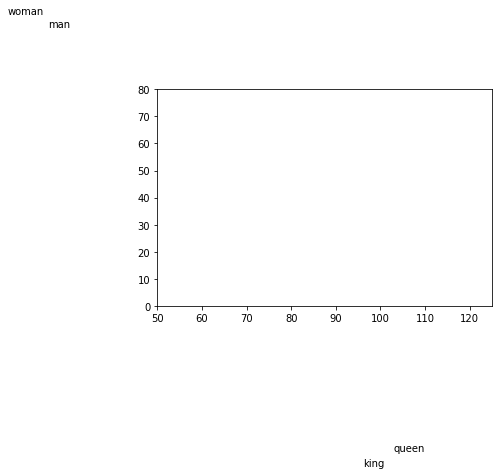

In [17]:
tsne = TSNE(n_components=2)
words_array = []
word_list = ['king','queen','man','woman']

for w in word_list:
    words_array.append(embeddings_index[w])

index1 = list(embeddings_index.keys())[0:100]

for i in range(100):
    words_array.append(embeddings_index[index1[i]])
words_array = np.array(words_array)
words_tsne = tsne.fit_transform(words_array)

ax = plt.subplot(111)

for i in range(4):
    plt.text(words_tsne[i, 0], words_tsne[i, 1],word_list[i])

plt.xlim((50,125))
plt.ylim((0,80)) 
plt.show() 

# Listing 4-3. TensorFlow Implementation of Reccurent Neural Network using LSTM for Classification

In [19]:
##################################
#Import the Required Libraries
##################################

import tensorflow as tf
import numpy as np
from tensorflow.keras import Model, layers

def read_infile():
    (train_X, train_Y), (test_X, test_Y) = tf.keras.datasets.mnist.load_data()
    train_X,test_X = np.expand_dims(train_X, -1), np.expand_dims(test_X,-1)
    #print(train_X.shape,test_X.shape)
    return train_X, train_Y,test_X, test_Y

def normalize(train_X):
    return train_X/255.0


class RNN_network(Model):
    
    def __init__(self,hidden_dim,num_classes):
        super(RNN_network,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        
        self.lstm = layers.LSTM(hidden_dim, return_sequences=False, return_state=False)
        self.out = layers.Dense(num_classes)
        
   
    def call(self,x):
        x = self.lstm(x)
        x = self.out(x)
        return x
        
        
def train(epochs=10,lr=0.01,hidden_dim=64,batch_size=32,n_steps=28,n_inputs=28):
    
    X_train, y_train, X_test, y_test = read_infile()
    X_train, X_test = normalize(X_train), normalize(X_test)
    num_train_recs, num_test_recs = X_train.shape[0], X_test.shape[0]
    
    model = RNN_network(hidden_dim=hidden_dim,num_classes=10)
    #model_graph = tf.function(model)
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.SUM)
    
    optimizer = tf.keras.optimizers.Adam(lr)
    
    num_train_recs,num_test_recs = X_train.shape[0], X_test.shape[0]
    num_batches = num_train_recs // batch_size
    num_batches_test = num_test_recs //batch_size
    order_ = np.arange(num_train_recs)
    loss_trace,accuracy_trace = [], []
    start_time = time.time()
    for i in range(epochs):
        loss, accuracy = 0,0
        np.random.shuffle(order_)
        X_train,y_train = X_train[order_], y_train[order_]
        for j in range(num_batches):
            X_train_batch = tf.constant(X_train[j*batch_size:(j+1)*batch_size].reshape((batch_size, n_steps, n_inputs)),dtype=tf.float32)
            y_train_batch = tf.constant(y_train[j*batch_size:(j+1)*batch_size]) 
            #print(X_train_batch, y_train_batch)
           
            with tf.GradientTape() as tape:
                y_pred_batch = model(X_train_batch)
                loss_ = loss_fn(y_train_batch,y_pred_batch)


                # compute gradient
            gradients = tape.gradient(loss_, model.trainable_variables)
                # update the parameters
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            accuracy += np.sum(y_train_batch.numpy() == np.argmax(y_pred_batch.numpy(),axis=1))
            loss += loss_.numpy()
        loss /= num_train_recs
        accuracy /= num_train_recs
        loss_trace.append(loss)
        accuracy_trace.append(accuracy)
        print(f"Epoch {i+1} : loss: {np.round(loss,4)} ,accuracy:{np.round(accuracy,4)}\n")
    
    test_accuracy = 0
    for j in range(num_batches_test):
        X_test_batch = tf.constant(X_test[j*batch_size:(j+1)*batch_size].reshape((batch_size, n_steps, n_inputs)),dtype=tf.float32)
        y_test_batch = tf.constant(y_test[j*batch_size:(j+1)*batch_size]) 
        y_pred_batch = model(X_test_batch)
        test_accuracy += np.sum(y_test_batch.numpy() == np.argmax(y_pred_batch.numpy(),axis=1))
    print(f"Test accuracy : {test_accuracy/num_test_recs}")
        
train()

Epoch 1 : loss: 0.2713 ,accuracy:0.9144

Epoch 2 : loss: 0.1151 ,accuracy:0.9658

Epoch 3 : loss: 0.0947 ,accuracy:0.9716

Epoch 4 : loss: 0.0866 ,accuracy:0.9745

Epoch 5 : loss: 0.0875 ,accuracy:0.9739

Epoch 6 : loss: 0.092 ,accuracy:0.9728

Epoch 7 : loss: 0.0936 ,accuracy:0.9722

Epoch 8 : loss: 0.0899 ,accuracy:0.973

Epoch 9 : loss: 0.083 ,accuracy:0.9751

Epoch 10 : loss: 0.0813 ,accuracy:0.9759

Test accuracy : 0.9672


# Listing 4-4. Next word Prediction and sentence completion in TensorFlow using Recurrent Neural Network 

In [20]:
import numpy as np
import tensorflow as tf
import random
import collections
import time
# Parameters





def read_data(fname):
    with open(fname) as f:
        data = f.readlines()
    data = [x.strip() for x in data]
    data = [data[i].lower().split() for i in range(len(data))]
    data = np.array(data)
    data = np.reshape(data, [-1, ])
    return data


train_file = '/home/santanu/Downloads/alice_in_wonderland.txt'
train_data = read_data(train_file)
print(train_data)


def build_dataset(train_data):
    #print(train_data)
    count = collections.Counter(train_data).most_common()
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary




def input_one_hot(num,vocab_size):
    x = np.zeros(vocab_size)
    x[num] = 1 
    return x.tolist()

class RNN_network(Model):
    
    def __init__(self,hidden_dim,num_classes):
        super(RNN_network,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        
        self.lstm = layers.LSTM(hidden_dim, return_sequences=False, return_state=False)
        self.out = layers.Dense(num_classes)
        
   
    def call(self,x):
        x = self.lstm(x)
        x = self.out(x)
        return x
        


def train(n_input=3,n_hidden=512,lr=0.001,training_iters = 50000,display_step = 500):
    dictionary, reverse_dictionary = build_dataset(train_data)
    vocab_size = len(dictionary)
    model = RNN_network(hidden_dim=n_hidden,num_classes=vocab_size)
    print(model)
    # Launch the graph
    step = 0
    offset = random.randint(0,n_input+1)
    end_offset = n_input + 1
    acc_total = 0
    loss_total = 0
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.SUM)
    optimizer = tf.keras.optimizers.Adam(lr)

    while step < training_iters:
        if offset > (len(train_data)-end_offset):
            offset = random.randint(0, n_input+1)

        symbols_in_keys = [ input_one_hot(dictionary[ str(train_data[i])],vocab_size=vocab_size) for i in range(offset, offset+n_input) ]
        symbols_in_keys = tf.constant(np.reshape(np.array(symbols_in_keys), [-1, n_input,vocab_size]))
        symbols_out_onehot = np.zeros([vocab_size], dtype=float)
        symbols_out_onehot[dictionary[str(train_data[offset+n_input])]] = 1.0
        symbols_out_onehot = tf.constant(np.reshape(symbols_out_onehot,[1,-1]))
        with tf.GradientTape() as tape:
            onehot_pred = model(symbols_in_keys)
            loss_ = loss_fn(symbols_out_onehot,onehot_pred)


        # compute gradient
        gradients = tape.gradient(loss_, model.trainable_variables)
        # update the parameters
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        acc_total += np.sum(np.argmax(symbols_out_onehot.numpy(),axis=1) == np.argmax(onehot_pred.numpy(),axis=1))
        loss_total += loss_.numpy()
        
        if step % display_step == 0:
            print("Iter= " + str(step) + ", Average Loss= " + \
                      "{:.6f}".format(loss_total/display_step) + ", Average Accuracy= " + \
                      "{:.2f}%".format(100*acc_total/display_step))
            acc_total = 0
            loss_total = 0
            symbols_in = [train_data[i] for i in range(offset, offset + n_input)]
            symbols_out = train_data[offset + n_input]
            symbols_out_pred = reverse_dictionary[int(tf.argmax(onehot_pred, 1))]
            print("%s - Actual word:[%s] vs Predicted word:[%s]" % (symbols_in,symbols_out,symbols_out_pred))
        step += 1
        offset += (n_input+1)
        

        sentence = 'i only wish'
        words = sentence.split(' ')
    try:
        symbols_in_keys = [ input_one_hot(dictionary[ str(train_data[i])]) for i in range(offset, offset+n_input) ]
        for i in range(28):
            keys = np.reshape(np.array(symbols_in_keys), [-1, n_input,vocab_size])
            onehot_pred = model(keys)
            onehot_pred_index = int(tf.argmax(onehot_pred, 1))
            sentence = "%s %s" % (sentence,reverse_dictionary[onehot_pred_index])
            symbols_in_keys = symbols_in_keys[1:]
            symbols_in_keys.append(input_one_hot(onehot_pred_index))
            print(sentence)
    except:
        print("Word not in dictionary")
    print("Optimization Finished!")
train()

["'" 'you' "can't" 'think' 'how' 'glad' 'i' 'am' 'to' 'see' 'you' 'again'
 ',' 'you' 'dear' 'old' 'thing' '!' "'" 'said' 'the' 'duchess' ',' 'as'
 'she' 'tucked' 'her' 'arm' 'affectionately' 'into' "alice's" ',' 'and'
 'they' 'walked' 'off' 'together' '.' 'alice' 'was' 'very' 'glad' 'to'
 'find' 'her' 'in' 'such' 'a' 'pleasant' 'temper' ',' 'and' 'thought' 'to'
 'herself' 'that' 'perhaps' 'it' 'was' 'only' 'the' 'pepper' 'that' 'had'
 'made' 'her' 'so' 'savage' 'when' 'they' 'met' 'in' 'the' 'kitchen' '.'
 "'" 'when' "i'm" 'a' 'duchess' ',' "'" 'she' 'said' 'to' 'herself' ','
 '(' 'not' 'in' 'a' 'very' 'hopeful' 'tone' 'though' ')' ',' "'" 'i'
 "won't" 'have' 'any' 'pepper' 'in' 'my' 'kitchen' 'at' 'all' '.' 'soup'
 'does' 'very' 'well' 'without' '—' 'maybe' "it's" 'always' 'pepper'
 'that' 'makes' 'people' 'hot-tempered' ',' "'" 'she' 'went' 'on' ','
 'very' 'much' 'pleased' 'at' 'having' 'found' 'out' 'a' 'new' 'kind' 'of'
 'rule' ',' "'" 'and' 'vinegar' 'that' 'makes' 'them' 'sour' 

# Listing 4-5 : Text used to train the model in Listing 4-4


' You can't think how glad I am to see you again, you dear old thing ! '
said the Duchess, as she tucked her arm affectionately into Alice's, and
they walked off together . Alice was very glad to find her in such a
pleasant temper, and thought to herself that perhaps it was only the pepper
that had made her so savage when they met in the kitchen . ' When I'm a
Duchess, ' she said to herself, ( not in a very hopeful tone though ),
' I won't have any pepper in my kitchen at all . Soup does very well without — Maybe it's always pepper that makes people hot-tempered, ' she went on, very much pleased at having found out a new kind of rule, ' and vinegar that makes them sour — and camomile that makes them bitter — and — and barley-sugar and such things that make children sweet-tempered . I
only wish people knew that : then they wouldn't be so stingy about it, you know — 'She had quite forgotten the Duchess by this time, and was a little startled when she heard her voice close to her ear . ' You're thinking about something, my dear, and that makes you forget to talk . I can't tell you just now what the moral of that is, but I shall remember it in a bit . ' ' Perhaps it hasn't one, ' Alice ventured to remark . ' Tut, tut, child ! ' said the Duchess . ' Everything's got a moral, if only you can find it .
' And she squeezed herself up closer to Alice's side as she spoke . Alice did not much like keeping so close to her : first, because the Duchess was very ugly ; and secondly, because she was exactly the right height to rest her chin upon Alice's shoulder, and it was an uncomfortably sharp chin . However, she did not like to be rude, so she bore it as well as she could .


# Listing 4-6. Neural Machine Translation Using Seq2Seq Model

In [1]:
import  tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import numpy as np
import codecs
import pandas as pd
import pickle
from elapsedtimer import ElapsedTimer
from  pathlib import Path
import os


# Machine Translation Model - English to French

class MachineTranslation:

    def __init__(self,
                 path,
                 epochs=20,
                 batch_size=32,
                 latent_dim=128,
                 num_samples=40000,
                 outdir=None,
                 verbose=True,
                 mode='train',
                 embedding_dim=128):
        
        self.path = path
        self.epochs = epochs
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.embedding_dim = embedding_dim
        self.num_samples = num_samples
        self.outdir = outdir
        if self.outdir is not None:
            if not Path(self.outdir).exists():
                os.makedirs(Path(self.outdir))
        self.verbose = verbose
        self.mode = mode

    def read_input(self, path, num_samples=10e13):
        input_texts = []
        target_texts = []
        input_words = set()
        target_words = set()

        with codecs.open(path, 'r', encoding='utf-8') as f:
            lines = f.read().split('\n')

        for line in lines[: min(num_samples, len(lines) - 1)]:
            input_text, target_text = line.split('\t')  # \t as the start of sequence 
            target_text = '\t ' + target_text + ' \n'  # \n as the end  of sequence
            input_texts.append(input_text)
            target_texts.append(target_text)
            for word in input_text.split(" "):
                if word not in input_words:
                    input_words.add(word)
            for word in target_text.split(" "):
                if word not in target_words:
                    target_words.add(word)

        return input_texts, target_texts, input_words, target_words

    def generate_vocab(self, path, num_samples, verbose=True):

        input_texts, target_texts, input_words, target_words = self.read_input(path, num_samples)
        input_words = sorted(list(input_words))
        target_words = sorted(list(target_words))
        self.num_encoder_words = len(input_words)
        self.num_decoder_words = len(target_words)
        self.max_encoder_seq_length = max([len(txt.split(" ")) for txt in input_texts])
        self.max_decoder_seq_length = max([len(txt.split(" ")) for txt in target_texts])

        if verbose == True:
            print('Number of samples:', len(input_texts))
            print('Number of unique input tokens:', self.num_encoder_words)
            print('Number of unique output tokens:', self.num_decoder_words)
            print('Max sequence length for inputs:', self.max_encoder_seq_length)
            print('Max sequence length for outputs:', self.max_decoder_seq_length)

        self.input_word_index = dict(
            [(word, i) for i, word in enumerate(input_words)])
        self.target_word_index = dict(
            [(word, i) for i, word in enumerate(target_words)])
        self.reverse_input_word_dict = dict(
            (i, word) for word, i in self.input_word_index.items())
        self.reverse_target_word_dict = dict(
            (i, word) for word, i in self.target_word_index.items())

    def process_input(self, input_texts, target_texts=None, verbose=True):

        encoder_input_data = np.zeros(
            (len(input_texts), self.max_encoder_seq_length),
            dtype='float32')

        decoder_input_data = np.zeros(
            (len(input_texts), self.max_decoder_seq_length),
            dtype='float32')

        decoder_target_data = np.zeros(
            (len(input_texts), self.max_decoder_seq_length, 1),
            dtype='float32')

        if self.mode == 'train':
            for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
                for t, word in enumerate(input_text.split(" ")):
                    try:
                        encoder_input_data[i, t] = self.input_word_index[word]
                    except:
                        encoder_input_data[i, t] = self.num_encoder_words

                for t, word in enumerate(target_text.split(" ")):
                    # decoder_target_data is ahead of decoder_input_data by one timestep
                    try:
                        decoder_input_data[i, t] = self.target_word_index[word]
                    except:
                        decoder_input_data[i, t] = self.num_decoder_words
                    if t > 0:
                        # decoder_target_data will be ahead by one timestep
                        # and will not include the start character.
                        try:
                            decoder_target_data[i, t - 1] = self.target_word_index[word]
                        except:
                            decoder_target_data[i, t - 1] = self.num_decoder_words
            print(self.num_encoder_words)
            print(self.num_decoder_words)
            print(self.embedding_dim)
            self.english_emb = np.zeros((self.num_encoder_words + 1, self.embedding_dim))
            self.french_emb = np.zeros((self.num_decoder_words + 1, self.embedding_dim))
            return encoder_input_data, decoder_input_data, decoder_target_data, np.array(input_texts), np.array(
                target_texts)
        else:
            for i, input_text in enumerate(input_texts):
                for t, word in enumerate(input_text.split(" ")):
                    try:
                        encoder_input_data[i, t] = self.input_word_index[word]
                    except:
                        encoder_input_data[i, t] = self.num_encoder_words

            return encoder_input_data, None, None, np.array(input_texts), None

    def train_test_split(self, num_recs, train_frac=0.8):
        rec_indices = np.arange(num_recs)
        np.random.shuffle(rec_indices)
        train_count = int(num_recs * 0.8)
        train_indices = rec_indices[:train_count]
        test_indices = rec_indices[train_count:]
        return train_indices, test_indices

    def model(self):
        # Encoder Model
        encoder_inp = Input(shape=(None,), name='encoder_inp')
        encoder_inp1 = Embedding(self.num_encoder_words + 1, self.embedding_dim, weights=[self.english_emb])(
            encoder_inp)
        encoder = LSTM(self.latent_dim, return_state=True, name='encoder')
        encoder_out, state_h, state_c = encoder(encoder_inp1)
        encoder_states = [state_h, state_c]

        # Decoder Model
        decoder_inp = Input(shape=(None,), name='decoder_inp')
        decoder_inp1 = Embedding(self.num_decoder_words + 1, self.embedding_dim, weights=[self.french_emb])(decoder_inp)
        decoder_lstm = LSTM(self.latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
        decoder_out, _, _ = decoder_lstm(decoder_inp1, initial_state=encoder_states)
        decoder_dense = Dense(self.num_decoder_words, activation='softmax', name='decoder_dense')
        decoder_out = decoder_dense(decoder_out)
        print(np.shape(decoder_out))
        # Combined Encoder Decoder Model
        model = Model([encoder_inp, decoder_inp], decoder_out)
        # Encoder Model 
        encoder_model = Model(encoder_inp, encoder_states)
        # Decoder Model
        decoder_inp_h = Input(shape=(self.latent_dim,))
        decoder_inp_c = Input(shape=(self.latent_dim,))
        decoder_inp_state = [decoder_inp_h, decoder_inp_c]
        decoder_out, decoder_out_h, decoder_out_c = decoder_lstm(decoder_inp1, initial_state=decoder_inp_state)
        decoder_out = decoder_dense(decoder_out)
        decoder_out_state = [decoder_out_h, decoder_out_c]
        decoder_model = Model(inputs=[decoder_inp] + decoder_inp_state, outputs=[decoder_out] + decoder_out_state)

        return model, encoder_model, decoder_model

    def decode_sequence(self, input_seq, encoder_model, decoder_model):
        # Encode the input as state vectors.
        states_value = encoder_model.predict(input_seq)

        # Generate empty target sequence of length 1.
        target_seq = np.zeros((1, 1))
        # Populate the first character of target sequence with the start character.
        target_seq[0, 0] = self.target_word_index['\t']

        # Sampling loop for a batch of sequences
        stop_condition = False
        decoded_sentence = ''

        while not stop_condition:
            output_word, h, c = decoder_model.predict(
                [target_seq] + states_value)

            # Sample a token
            sampled_word_index = np.argmax(output_word[0, -1, :])
            try:
                sampled_char = self.reverse_target_word_dict[sampled_word_index]
            except:
                sampled_char = '<unknown>'
            decoded_sentence = decoded_sentence + ' ' + sampled_char

            # Exit condition: either hit max length
            # or find stop character.
            if (sampled_char == '\n' or
                    len(decoded_sentence) > self.max_decoder_seq_length):
                stop_condition = True

            # Update the target sequence (of length 1).
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_word_index

            # Update states
            states_value = [h, c]

        return decoded_sentence

    # Run training

    def train(self, encoder_input_data, decoder_input_data, decoder_target_data):
        print("Training...")

        print(np.shape(encoder_input_data))
        print(np.shape(decoder_input_data))
        print(np.shape(decoder_target_data))

        model, encoder_model, decoder_model = self.model()

        model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
        model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                  batch_size=self.batch_size,
                  epochs=self.epochs,
                  validation_split=0.2)
        # Save model
        model.save(self.outdir + 'eng_2_french_dumm.h5')
        return model, encoder_model, decoder_model

    def inference(self, model, data, encoder_model, decoder_model, in_text):
        in_list, out_list = [], []
        for seq_index in range(data.shape[0]):
            input_seq = data[seq_index: seq_index + 1]
            decoded_sentence = self.decode_sequence(input_seq, encoder_model, decoder_model)
            print('-')
            print('Input sentence:', in_text[seq_index])
            print('Decoded sentence:', decoded_sentence)
            in_list.append(in_text[seq_index])
            out_list.append(decoded_sentence)
        return in_list, out_list

    def save_models(self, outdir):
        self.model.save(outdir + 'enc_dec_model.h5')
        self.encoder_model.save(outdir + 'enc_model.h5')
        self.decoder_model.save(outdir + 'dec_model.h5')

        variables_store = {'num_encoder_words': self.num_encoder_words,
                           'num_decoder_words': self.num_decoder_words,
                           'max_encoder_seq_length': self.max_encoder_seq_length,
                           'max_decoder_seq_length': self.max_decoder_seq_length,
                           'input_word_index': self.input_word_index,
                           'target_word_index': self.target_word_index,
                           'reverse_input_word_dict': self.reverse_input_word_dict,
                           'reverse_target_word_dict': self.reverse_target_word_dict
                           }
        with open(outdir + 'variable_store.pkl', 'wb') as f:
            pickle.dump(variables_store, f)
            f.close()

    def load_models(self, outdir):
        self.model = load_model(outdir + 'enc_dec_model.h5')
        self.encoder_model = load_model(outdir + 'enc_model.h5')
        self.decoder_model = load_model(outdir + 'dec_model.h5')

        with open(outdir + 'variable_store.pkl', 'rb') as f:
            variables_store = pickle.load(f)
            f.close()

        self.num_encoder_words = variables_store['num_encoder_words']
        self.num_decoder_words = variables_store['num_decoder_words']
        self.max_encoder_seq_length = variables_store['max_encoder_seq_length']
        self.max_decoder_seq_length = variables_store['max_decoder_seq_length']
        self.input_word_index = variables_store['input_word_index']
        self.target_word_index = variables_store['target_word_index']
        self.reverse_input_word_dict = variables_store['reverse_input_word_dict']
        self.reverse_target_word_dict = variables_store['reverse_target_word_dict']

    def main(self):

        if self.mode == 'train':
            self.generate_vocab(self.path, self.num_samples, self.verbose)  # Generate the vocabulary
            input_texts, target_texts, _, _ = self.read_input(self.path, self.num_samples)
            encoder_input_data, decoder_input_data, decoder_target_data, input_texts, target_texts = \
                self.process_input(input_texts, target_texts, True)
            num_recs = encoder_input_data.shape[0]
            train_indices, test_indices = self.train_test_split(num_recs, 0.8)
            encoder_input_train_X, encoder_input_test_X = encoder_input_data[train_indices,], encoder_input_data[
                test_indices,]
            decoder_input_train_X, decoder_input_test_X = decoder_input_data[train_indices,], decoder_input_data[
                test_indices,]
            decoder_target_train_y, decoder_target_test_y = decoder_target_data[train_indices,], decoder_target_data[
                test_indices,]
            input_text_train, input_text_test = input_texts[train_indices], input_texts[test_indices]
            self.model, self.encoder_model, self.decoder_model = self.train(encoder_input_train_X,
                                                                            decoder_input_train_X,
                                                                            decoder_target_train_y)
            in_list, out_list = self.inference(self.model, encoder_input_test_X, self.encoder_model,
                                               self.decoder_model, input_text_test)
            out_df = pd.DataFrame()
            out_df['English text'] = in_list
            out_df['French text'] = out_list
            out_df.to_csv(self.outdir + 'hold_out_results_val.csv', index=False)
            self.save_models(self.outdir)

        else:
            self.load_models(self.outdir)
            input_texts, _, _, _ = self.read_input(self.path, self.num_samples)
            encoder_input_data, _, _, input_texts, _ = \
                self.process_input(input_texts, '', True)
            in_list, out_list = self.inference(self.model, encoder_input_test_X, self.encoder_model,
                                               self.decoder_model, input_text_test)
            out_df = pd.DataFrame()
            out_df['English text'] = in_list
            out_df['French text'] = out_list
            out_df.to_csv(self.outdir + 'results_test.csv', index=False)



translator = MachineTranslation(path='/home/santanu/ML_DS_Catalog-/Machine Translation/fra-eng/fra.txt',
                             outdir='/home/santanu/machine_translation/output',epochs=10)
translator.main()
        


2022-08-12 22:33:32.078729: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-8.0/lib64:/usr/local/cuda/extras/CUPTI/lib64
2022-08-12 22:33:32.078758: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.9.1
Number of samples: 40000
Number of unique input tokens: 8658
Number of unique output tokens: 16297
Max sequence length for inputs: 7
Max sequence length for outputs: 16
8658
16297
128
Training...
(32000, 7)
(32000, 16)
(32000, 16, 1)


2022-08-12 22:33:34.123485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-12 22:33:34.124420: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-8.0/lib64:/usr/local/cuda/extras/CUPTI/lib64
2022-08-12 22:33:34.124497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-8.0/lib64:/usr/local/cuda/extras/CUPTI/lib64
2022-08-12 22:33:34.124556: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt

(None, None, 16297)
Epoch 1/10
800/800 [==============================] - 79s 96ms/step - loss: 1.8982 - val_loss: 1.5831